In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from single_dorm_simulation import SingleDormSimulation

In [31]:
def sample_dorm_infection_data(contacts_per_day, high_alert_test_rate, procnum, return_dict):
    high_alert_contacts_per_day = max(0, contacts_per_day - 5)
    dorm_sim = SingleDormSimulation(dorm_population=100,
                                    dorm_test_rate=0.2,
                                    high_alert_dorm_test_rate=high_alert_test_rate,
                                    contacts_per_day=contacts_per_day,
                                    high_alert_contacts_per_day=contacts_per_day,
                                    initial_cases=1)
    t, d = dorm_sim.run_multiple_until_controlled(ntrajectories=750)
    return_dict[procnum] = {'total_infected': t, 'days_to_control': d}



In [32]:
import multiprocessing, time, itertools

manager = multiprocessing.Manager()
return_dict = manager.dict()
jobs = []
high_test_rates = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
contacts_per_days = [10.3, 11.3, 12.3, 13.3, 14.3, 15.3]

start = time.time()
idx = 0
idx_mapping = {}
for high_alert_test_rate, contacts in itertools.product(high_test_rates, contacts_per_days):
    p = multiprocessing.Process(target=sample_dorm_infection_data, 
                                args=(contacts, high_alert_test_rate, idx,return_dict))
    idx_mapping[idx] = (high_alert_test_rate, contacts)
    jobs.append(p)
    p.start()
    idx += 1
    
for proc in jobs:
        proc.join()
end = time.time()
print("elapsed time: {:.2f} seconds".format(end-start))

elapsed time: 790.76 seconds


In [6]:
import itertools
list(itertools.product([1,2,3],[4,5,6]))

[(1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)]

In [33]:
mapping_to_idx = {}
for idx in idx_mapping:
    test_rate, contacts = idx_mapping[idx]
    mapping_to_idx[(test_rate, contacts)] = idx

In [38]:
Y_test_rates = np.array(high_test_rates)
X_contacts = np.array(contacts_per_days)

Z_infections = np.zeros((len(contacts_per_days), len(high_test_rates)))

for i, contacts in enumerate(X_contacts):
    for j, test_rate in enumerate(Y_test_rates):
        idx = mapping_to_idx[(test_rate, contacts)]
        Z_infections[i,j] = np.mean(return_dict[idx]['total_infected'])


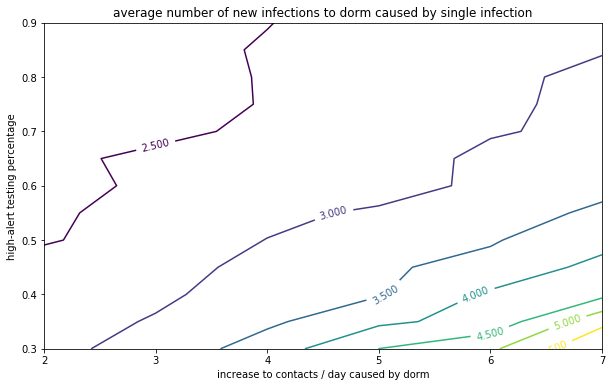

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.xlabel("increase to contacts / day caused by dorm")
plt.ylabel("high-alert testing percentage")
plt.title("average number of new infections to dorm caused by single infection")
CS = plt.contour(X_contacts - np.array([8.3] * len(X_contacts)), Y_test_rates, Z_infections.T)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()